In [1]:
import pandas as pd
import numpy as np
import itertools
import re

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib import cm
from datetime import datetime
from ipywidgets import widgets  
from IPython.display import display


from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.metrics import log_loss

from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint

from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

import xgboost as xgb

print "imports imported"

imports imported


In [2]:
crimeData = pd.read_csv('./../train.csv')
Categories = ['ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY',
              'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE',
              'DRUG/NARCOTIC', 'DRUNKENNESS', 'EMBEZZLEMENT', 'EXTORTION',
              'FAMILY OFFENSES', 'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING',
              'KIDNAPPING', 'LARCENY/THEFT', 'LIQUOR LAWS', 'LOITERING',
              'MISSING PERSON', 'NON-CRIMINAL', 'OTHER OFFENSES',
              'PORNOGRAPHY/OBSCENE MAT', 'PROSTITUTION', 'RECOVERED VEHICLE',
              'ROBBERY', 'RUNAWAY', 'SECONDARY CODES', 'SEX OFFENSES FORCIBLE',
              'SEX OFFENSES NON FORCIBLE', 'STOLEN PROPERTY', 'SUICIDE',
              'SUSPICIOUS OCC', 'TREA', 'TRESPASS', 'VANDALISM', 'VEHICLE THEFT',
              'WARRANTS', 'WEAPON LAWS']

In [3]:
def recodeData(df, isTrain = False):
    '''This function takes in the dataframe that we get from loading in the 
    SF crime data and returns a re-coded dataframe that has all the 
    additional features we want to add and the categorical features recoded 
    and cleaned.
    '''

    #since the modifications are done in-place we don't return the dataframe. 
    #we do, however, return the list of all the columns we added.
    df, newLatLon = removeOutlierLatLon(df)
    df, newDate = recodeDates(df)
    df, newDistrict = recodePoliceDistricts(df)
    print "recoding addresses"
    df, newAddress, streetColumns = recodeAddresses(df)

    
    addedColumns = [] 
    addedColumns += newDate
    addedColumns += newDistrict 
    addedColumns += newLatLon
    addedColumns += newAddress
    
    
   

    if (isTrain):
        newCategory = recodeCategories(df)
        addedColumns += newCategory
        try: #prevents error if the coumns have already been removed or we are processing test data
            columnsToDrop = ['Descript', 'Resolution']
            df.drop(columnsToDrop, axis=1, inplace=True)
        except:
            print "already recoded or using test data"
         

    return df, addedColumns, streetColumns

In [4]:
def recodeDates(df):
    '''This function takes in a dataframe and recodes the date field into 
    useable values. Here, we also recode the day of week.'''
    #Recode the dates column to year, month, day and hour columns
    df['DateTime'] = df['Dates'].apply(
        lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

    df['Year'] = df['DateTime'].apply(lambda x: x.year)
    df['Month'] = df['DateTime'].apply(lambda x: x.month)
    df['Day'] = df['DateTime'].apply(lambda x: x.day)
    df['Hour'] = df['DateTime'].apply(lambda x: x.hour)
    df['Minute'] = df['DateTime'].apply(lambda x: x.minute)
    df['DayOfWeekRecode'] = df['DateTime'].apply(lambda x: x.weekday())
    df['MinuteOfWeek'] = df['DateTime'].apply(lambda x: x.weekday()*24*60 + x.hour*60 + x.minute)

    return df, ['Year', 'Month', 'Day', 'Hour', 'Minute', 'DayOfWeekRecode','MinuteOfWeek']

In [5]:
def recodePoliceDistricts(df):
    '''This function recodes the police district to a one-hot encoding 
    scheme.'''
    districts = df['PdDistrict'].unique().tolist()
    newColumns = []
    for district in districts:
        newColumns.append('District' + district)
        df['District' + district] = df['PdDistrict'].apply(
            lambda x: int(x == district))

    return df, newColumns

In [6]:
def recodeAddresses(df):
    '''This function will attempt to create some features related to the address field in the database. To do this, 
    first, we need to split up the address field into two different address fields'''
    
    #If there are two addresss, split fields. Also extract the block number
    df['Address1'] = df['Address'].apply(lambda x: re.sub(r'^\d+ Block of ','',x.split(" / ")[0]))
    df['Address2'] = df['Address'].apply(lambda x: (x.split(" / ")[1]) if (len(x.split(" / ")) > 1) else None)
    df['BlockNumber'] = df['Address'].apply(lambda x: int(re.findall(r'^\d+',x)[0]) if (len(re.findall(r'^\d+',x)) > 0) else None )
    df['BlockNumber'] = df['BlockNumber'].fillna(-1)
    
    #Also add the "did the crime occur on a street corner field?"
    df['StreetCornerFlag'] = df['Address'].apply(lambda x: len(x.split(" / ")) > 1)
    
    return df, ['StreetCornerFlag', 'BlockNumber'], []

In [7]:
def removeOutlierLatLon(df):
    '''This function will attempt remove outlier Latitudes and Longitudes'''
    df.loc[df.X > -121, 'X'] = df.loc[(df.X > -121)].apply(lambda row: df.X[df["PdDistrict"] == row['PdDistrict']].median(), axis=1)
    df.loc[df.Y > 38, 'Y'] = df.loc[(df.Y > 38)].apply(lambda row: df.Y[df["PdDistrict"] == row['PdDistrict']].median(), axis=1)

    return df, ['X', 'Y']

In [8]:
def recodeCategories(df):
    '''This function will attempt remove outlier Latitudes and Longitudes'''
    #if 'Category' in df.columns:
    df['CategoryRecode'] = df.Category.apply(lambda x: Categories.index(x))
        
    return df, ['CategoryRecode']

In [10]:
crimeData, addedColumns, streetColumns = recodeData(crimeData, isTrain = True)
crimeData.describe()

recoding addresses


,X,Y,Year,Month,Day,Hour,Minute,DayOfWeekRecode,MinuteOfWeek,DistrictNORTHERN,...,DistrictBAYVIEW,DistrictRICHMOND,DistrictCENTRAL,DistrictTARAVAL,DistrictTENDERLOIN,DistrictMISSION,DistrictSOUTHERN,BlockNumber,StreetCornerFlag,CategoryRecode
count,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,...,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049,878049.000000
mean,-122.422763,37.767035,2008.712046,6.436509,15.570623,13.412655,20.155026,2.992691,5134.388787,0.119920,...,0.101852,0.051488,0.097329,0.074707,0.093171,0.136562,0.179013,704.776747,0.297038,19.338687
std,0.025284,0.024165,3.631194,3.428972,8.783005,6.549573,18.594915,1.972023,2858.378361,0.324869,...,0.302454,0.220991,0.296406,0.262917,0.290673,0.343384,0.383363,1001.193208,0.456954,10.688637
min,-122.513642,37.707879,2003.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,False,0.000000
25%,-122.432952,37.752427,2006.000000,3.000000,8.000000,9.000000,0.000000,1.000000,2600.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,16.000000
50%,-122.416420,37.775421,2009.000000,6.000000,16.000000,14.000000,19.000000,3.000000,5220.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,300.000000,0,20.000000
75%,-122.406959,37.784368,2012.000000,9.000000,23.000000,19.000000,33.000000,5.000000,7606.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,1,25.000000
max,-122.364937,37.819975,2015.000000,12.000000,31.000000,23.000000,59.000000,6.000000,10079.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8300.000000,True,38.000000


In [11]:
columnsToUse = addedColumns

columnsToUse = ['X','Y', 'Year', 'Month', 'Day','Hour', 'Minute']
#        'DayOfWeekRecode', 'DistrictNORTHERN', 'DistrictPARK',
#        'DistrictINGLESIDE', 'DistrictBAYVIEW', 'DistrictRICHMOND',
#        'DistrictCENTRAL', 'DistrictTARAVAL', 'DistrictTENDERLOIN',
#        'DistrictMISSION', 'DistrictSOUTHERN', 'StreetCornerFlag']

X = crimeData[columnsToUse]
y = crimeData['CategoryRecode']

In [12]:
print("creating clf")
clf = xgb.XGBClassifier(max_depth=7, n_estimators=10, objective='multi:softprob', max_delta_step = 1, learning_rate = 1)
print("clf created")
k_folds = StratifiedShuffleSplit(y, 3, test_size=0.5, random_state=0)

scores = []
print "starting kfold testing"

for k, (train, test) in enumerate(k_folds):
    clf.fit(X.iloc[train], y.iloc[train], eval_metric = 'mlogloss',verbose = True)
    probs = clf.predict_proba(X.iloc[test])
    score = log_loss(y.iloc[test], probs)
    print score
    scores.append(score)
    
print(scores)
print("Average: " + str(np.average(scores)))

creating clf
clf created
starting kfold testing
2.35192627858
2.35725201034
2.35119171618
[2.351926278582634, 2.3572520103444092, 2.3511917161775613]
Average: 2.35345666837


To make a submission file, we modified the submission function from [this script](https://www.kaggle.com/shifanmao/sf-crime/random-forest-2/code). 

In [ ]:
def make_submission(clf, Xtrain, ytrain, predictors, path='my_submissionXGBoost.csv'):
    '''This function will take in a trained model, a list of predictors, and an optional 
    filepath and create a submissision file for us.'''
   
    test_data = pd.read_csv('./../test.csv')
    print "test data loaded"
    
    test_data, newColumns, streetColumns = recodeData(test_data)
    print "test data recoded"
    
    testDataColumns = list(test_data.columns.values)
    
    existingPredictors = list(set(predictors) & set(testDataColumns))
    
    clf.fit(Xtrain[existingPredictors], ytrain, eval_metric = 'mlogloss')
    print "model fitted with all data"
    
    #clf.fit(trainX[predictors], trainY)
    predictions = clf.predict_proba(test_data[existingPredictors])

    submission = pd.DataFrame({
        'Id': test_data.Id
    })
    
    for i in range(predictions.shape[1]):
        submission[Categories[i]] = predictions[:,i]
    submission.to_csv(path, index=False)

    print(" -- Wrote submission to file {}.".format(path))
    return existingPredictors

In [ ]:
predictorsUsed = make_submission(clf, X, y, columnsToUse)

In [ ]:
predictorsUsed


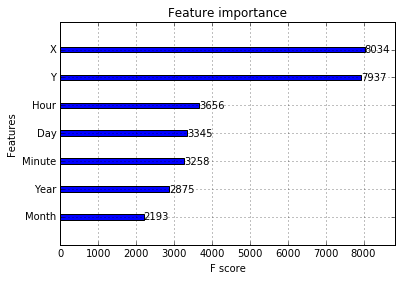

In [13]:
% matplotlib inline
xgb.plot_importance(clf)


So, we can see that X and Y data is by far the most important feature for this model